# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2020/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

*If you fail to follow these simple instructions, it will negatively impact your grade!*

**Due date and time**: The assignment is due on Tuesday November 3rd at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/.

### Overview

This year's Assignment 2 is all about analyzing the network of superheroes from the Marvel and DC universes. 

Note that this time, I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaning fully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----






**Exercise 1**: Visualize the network (from lecture 5) and calculate basic stats (from lecture 4). For this exercise, we assume that you've already generated the network of superheroes, report work on the giant connected component.

Here's what you need to do:

*Exercise 1a*: Stats (see lecture 4 for more hints)
* What is the number of nodes in the network?
* What is the number of links?
* What is the number of links connecting Marvel and DC? Explain in your own words what those links mean?
* Who are top 5 most connected characters? (Report results for in-degrees and out-degrees). Comment on your findings. Is this what you would have expected.
* Plot the in and out-degree distributions. 
  * Explain what you observe? 
  * Explain why the in-degree distribution is different from the out-degree distribution?
* Compare the degree distribution to a random network with the same number of nodes and probability of connection $p$. Comment or your results.

*Exercise 1b*: Visualization (see lecture 5 for more hints)

* Create a nice visualization of the total network.
  - Color nodes according to universe
  - Scale node-size according to degree
  - Whatever else you feel like.
  - If you can get it to work, get node positions based on the Force Atlas 2 algorithm

#  <font color='blue'>Preparation part: <br>Download the wiki pages of characters and build the network</font>

In [60]:
import csv
import requests
import json
import re
from tqdm import tqdm
import os
import networkx as nx
import collections
import matplotlib.pyplot as plt
from itertools import count
from fa2 import ForceAtlas2
from bs4 import BeautifulSoup as bs
import nltk
import pprint
from nltk.tokenize import word_tokenize

### <font color='blue'>(1) Download the Wikipedia pages of characters</font>

In [61]:
# as some wiki links contains symbols like ':' and '/' which is not allowed in file name
# then we use a function to replace those symbols when necessary

# get the name for file saving and reading
def file_saving_reading_name(s):
    s = s.replace(':','@')
    s = s.replace('/','$')
    return s

# get the name with ':' and '/'
def node_name(s):
    s = s.replace('@',':')
    s = s.replace('$','/')
    return s

In [64]:
# deal with the marvel part first
# marvel_file_path = './file/marvel_characters.csv'
marvel_file_path = '/Users/zhengqing/desktop/marvel_characters.csv'


# define a function to collect the wikiitems
def get_wiki_ittems(csv_file_path):
    wikiitems= []
    with open(csv_file_path, encoding="utf8") as f:
        csv_reader = csv.reader(f) 
        for row in csv_reader: 
            # for the dc file, every row end with ':'
            contents = row[0].split(';')[0]
            
            # the csv file is split by '\'
            contents = contents.split('|')
            
            # the first one is the number, and the third one is the kword if there's a link
            if len(contents) == 3 and contents[2]!=''and contents[0] != '':
                
                # collect the keywords
                # notice that the wiki links uses '_' for blank
                character_name = contents[1]
                link_keywords = contents[2].replace(' ','_')            

                # when it is with '#' it means that there's no wikilink for this character just appear somewhere in other character's pages
                # so we drop it
                # ask the TA , he suggest to use the part before #
                if len(link_keywords.split('#')) ==2 :
#                     print(keywords)
                    link_keywords = link_keywords.split('#')[0]
#                     print(keywords)
                # if there's '\"'， replace it with ''
                link_keywords = link_keywords.replace('"','')

                wikiitems.append(link_keywords)
    wikiitems = set(wikiitems)
    return wikiitems

wikiitems_marvel = get_wiki_ittems(marvel_file_path)

print(len(wikiitems_marvel))

1240


In [6]:
# print(wikiitems_marvel)

In [65]:
# get the dc wikiitems from csv
# dc_file_path = './file/dc_characters.csv'
dc_file_path = '/Users/zhengqing/desktop/dc_characters.csv'

wikiitems_dc = get_wiki_ittems(dc_file_path)

print(len(wikiitems_dc))

1040


In [66]:
# download the json file
# once you done it, skip this step forever, this is time consuming
# import tqdm library to view the progress bar while looping


baseurl = "https://en.wikipedia.org/w/api.php?"
action = "action=query"
content = "prop=revisions&rvprop=content"
dataformat ="format=json"

In [7]:
# json_path = '.\data\marvel2\\'
json_path = '/Users/zhengqing/desktop/marvel//'

for kwords in tqdm(wikiitems_marvel):
#     kwords = wikiitems_marvel[cha_name]
    title = "titles={}".format(kwords)
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    
    r = requests.get(query)
    text= r.text
    
    # remember to use the file saving and reading version of the kwords name
    with open(json_path+file_saving_reading_name(kwords)+'.json', 'w') as f:
        json.dump(text, f)

100%|██████████████████████████████████████████████████████████████████████████████| 1240/1240 [06:02<00:00,  3.42it/s]


In [8]:
# json_path = '.\data\dc2\\'
json_path = '/Users/zhengqing/desktop/dc//'

for kwords in tqdm(wikiitems_dc):
#     kwords = wikiitems_dc[cha_name]
    title = "titles={}".format(kwords)
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    
    r = requests.get(query)
    text= r.text
    
    with open(json_path+file_saving_reading_name(kwords)+'.json', 'w') as f:
        json.dump(text, f)

100%|██████████████████████████████████████████████████████████████████████████████| 1040/1040 [05:05<00:00,  3.40it/s]


### <font color='blue'>(2) Build the network</font>

In [67]:
# get the characters with the json file, as if the character do not have a json file, it means that this character do not have a link 
# so it will be discard anyway

# data_folder = '.\data\marvel2\\'
data_folder = '/Users/zhengqing/desktop/marvel'
def get_names(dir_):
    chas = []
    file_list = os.listdir(dir_)
    for f in file_list:
        name = f.split('.json')[0]
        name = node_name(name)
        chas.append(name)
    return chas

characters_marvel = get_names(data_folder)

print('Marvel character number:{} (which has wiki link)'.format(len(characters_marvel)))

Marvel character number:1241 (which has wiki link)


In [68]:
# deal with dc character
# data_folder = '.\data\dc2\\'
data_folder = '/Users/zhengqing/desktop/dc'
characters_dc = get_names(data_folder)

print('DC character number:{} (which has wiki link)'.format(len(characters_dc)))

DC character number:1040 (which has wiki link)


In [69]:
# use a json file to record the edges bewteen links
# get the wiki keywords from a certain text

def get_wiki_kwords(text):
    wikiitems = re.findall(r'\[\[[\(\)\w\s\-\|]*\]\]', text) 
    wikikwords = []
    for item in wikiitems:
        keywords = item[2:-2].split('|')[0].replace(' ','_')
        # remove the '[[',']]' and choose the first keyword if there's a '|', then replace the space with underline
        
        wikikwords.append(keywords)
    return wikikwords

In [70]:
# bulid the nodes
comics_cha = {}
for cha_name in characters_marvel:
    comics_cha[cha_name] = {}
    comics_cha[cha_name]['type'] = 'Marvel'
    comics_cha[cha_name]['edges'] = []
    
for dc_name in characters_dc:
    comics_cha[dc_name] = {}
    comics_cha[dc_name]['type'] = 'DC'
    comics_cha[dc_name]['edges'] = []
    

cha_all = characters_marvel+characters_dc

In [71]:
# for each node, search for the possible links
for cha_name in cha_all:
        # get the json file which contains the data of corresponding page
    if cha_name in characters_marvel:
            file_path = '/Users/zhengqing/desktop/marvel/'+file_saving_reading_name(cha_name)+'.json'
#             file_path = '.\data\marvel2\\'+file_saving_reading_name(cha_name)+'.json'
    else:
#             file_path = '.\data\dc2\\'+file_saving_reading_name(cha_name)+'.json'
            file_path = '/Users/zhengqing/desktop/dc/'+file_saving_reading_name(cha_name)+'.json'
    try:
        with open(file_path) as f:
            infor = json.load(f)
                 # extract all the links using regular expression
            kwords = get_wiki_kwords(infor)

            # to check whether the link is in character_name 
            cha_links = []
            for k in kwords:
                if k in comics_cha.keys(): cha_links.append(k)

            # avoid repeating
            cha_links = set(cha_links)


            # add the links to dict
            comics_cha[cha_name]['edges'].extend(cha_links)
    except:
        pass
   

# store the dataas json
# file_path = './data/comics_cha2.json'
file_path = '/Users/zhengqing/desktop/comics_cha.json'
with open(file_path, 'w') as f:
        json.dump(comics_cha, f)

In [72]:
G = nx.DiGraph()


# get the attribute from comics_cha
attr_dict = {}
for each in comics_cha:
    attr_dict[each] = comics_cha[each]['type']

# add nodes    
G.add_nodes_from(comics_cha.keys())
# add attribute of type
nx.set_node_attributes(G, attr_dict,'type')


# add links
for each in comics_cha:
    for link in comics_cha[each]['edges']:
        G.add_edge(each,link)

print('number of nodes in network:{}'.format(len(G.nodes())))
print('number of links in network:{}'.format(len(G.edges())))

number of nodes in network:2278
number of links in network:33387


#  <font color='blue'>Exercise 1a</font>

### (1) What is the number of nodes in the network?

In [31]:
print('number of nodes in network:{}'.format(len(G.nodes())))

number of nodes in network:2278


### (2) What is the number of links?

In [32]:
print('number of links in network:{}'.format(len(G.edges())))

number of links in network:33387


### (3) What is the number of links connecting Marvel and DC? Explain in your own words what those links mean?

In [33]:
links_connecting = []
for e in G.edges():
    if nx.get_node_attributes(G, 'type')[e[0]] != nx.get_node_attributes(G, 'type')[e[1]]:
        links_connecting.append(e)

In [35]:
num_of_connected_links = len(links_connecting)
print('There are {} links connect Marvel and DC. These links mean that there are at least {} directed relationship \
bewteen the Marvel and DC characters.'.format(num_of_connected_links,num_of_connected_links))

There are 781 links connect Marvel and DC. These links mean that there are at least 781 directed relationship bewteen the Marvel and DC characters.


### (4) Who are top 5 most connected characters? (Report results for in-degrees and out-degrees). Comment on your findings. Is this what you would have expected.

In [36]:
in_degrees = [(n,d) for n,d in G.in_degree()]
in_degrees.sort(key=lambda x: x[1],reverse= True)
print(in_degrees[0:5])

[('Spider-Man', 431), ('Superman', 405), ('Captain_America', 382), ('Batman', 382), ('Justice_League', 319)]


 The top 5 most connected characters(in-degrees) are <b> Spider-man, Superman, Batman, Captain_America and Justice_League.<b>

In [37]:
out_degrees = [(n,d) for n,d in G.out_degree()]
out_degrees.sort(key=lambda x: x[1],reverse= True)
print(out_degrees[0:5])

[('Hood_(comics)', 126), ('Venom_(Marvel_Comics_character)', 100), ('New_Warriors', 92), ('Justice_League', 89), ('Psylocke', 84)]


 The top 5 most connected characters(out-degrees) are <b> Hood_(comics), Venom_(Marvel_Comics_character), New_Warriors, Justice_League and Psylocke.<b>

**Comment on findings:**
<br>Take Spider-man as an example. In-degrees mean that the average edges of other nodes pointing to Spider-man node.It can be regarded as a reference to Spiderman in the Wikipage of other characters.Out-degrees mean that the average edges of Spider-man node pointing to other nodes, which could be regarded as a reference to other characters in the Wikipage of Spider-man.Hence, Spider-Man doesn't know as many people as anyone else knows him, he's a marvel Universe celebrity. We regard Spiderman as famous. Then there are similar characters (including in top5 list) as Batman, Captain America, Superman, Justice_League. These are famous characters. 
<br>As for out-degrees, take Hood_(comics) as an example. He is a mafia boss in the universe, so it could be concluded that he knows lots of characters.
<br>The findings are very close to what we expected.

### (5) Plot the in and out-degree distributions. 
  * <b>Explain what you observe? 
  * Explain why the in-degree distribution is different from the out-degree distribution?

In degree	max:431	min:0
Out degree	max:126	min:0
Nodes with in-degree larger than 100: 51


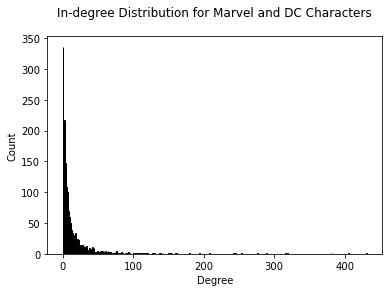

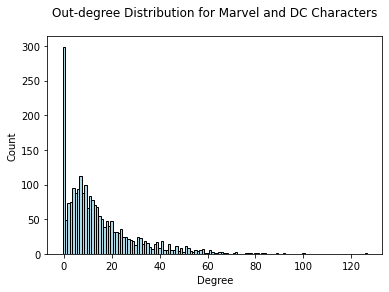

In [38]:
#in and out-degree distributions plots

in_degrees = [d for n,d in G.in_degree()]
out_degrees = [d for n,d in G.out_degree()]


def plot_degree_distribution(degrees,title):
    degreeCount = collections.Counter(degrees)
    degree, count = zip(*degreeCount.items())

    # plot
    width = 1.0
    plt.bar(degree, count, align='center', width=width,edgecolor ='black',color = 'lightblue')
    plt.title(title,pad = 20.0)
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.show()
    
print('In degree\tmax:{}\tmin:{}'.format(max(in_degrees),min(in_degrees)))
print('Out degree\tmax:{}\tmin:{}'.format(max(out_degrees),min(out_degrees)))
print('Nodes with in-degree larger than 100: {}'.format(len([i for i in in_degrees if i >100])))
plot_degree_distribution(in_degrees,'In-degree Distribution for Marvel and DC Characters')
plot_degree_distribution(out_degrees,'Out-degree Distribution for Marvel and DC Characters')

**Answer:**
<br>
**<font color='blue'>Obsevation:</font>**<br>
**<font color='red'>问答题疑问: 411这里展示一下，hub不确定用法, nina知道的话可以用，或者说得更通俗一点</font>**
<br>There is a hub in in-degree(which is 411), and the small in-degrees are in huge amount compared with out-degree. 
<br>**<font color='blue'>Explaination:</font>**
<br>According to the meaning of this network, each link represnts there is a link from page A to page B. Therefore, for unimportant characters, it will be less possible for them to be mentioned in other characters' page, which might cause the large amout of 0 and 1 in in-degrees. On the other hand, for very important characters who has lots of relationship with others, will have a larger probability of being a hub in in-degree.

### (6) Compare the degree distribution to a random network with the same number of nodes and probability of connection $p$. Comment or your results.

In [39]:
# calculate the number of nodes and p
N = len(G.nodes)
p = len(G.edges)/((N-1)*N)

print('N:{}\tp:{}'.format(N,p))

N:2278	p:0.0064366611490327946


In degree	max:35	min:3
Out degree	max:32	min:4
Nodes with in-degree larger than 100: 0


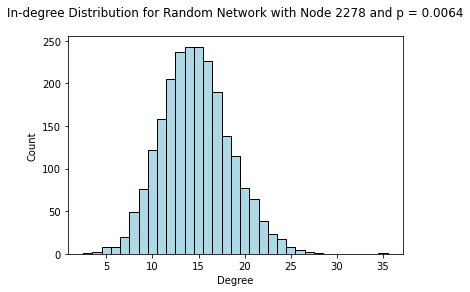

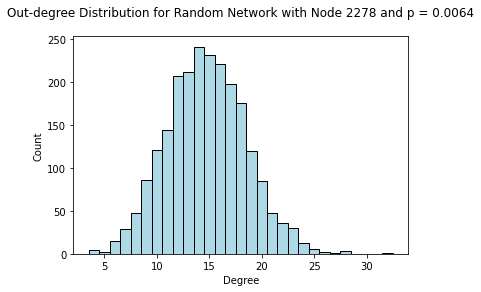

In [40]:
G_ER = nx.erdos_renyi_graph(N,p,seed=2020,directed = True)

in_degrees = [d for n,d in G_ER.in_degree()]
out_degrees = [d for n,d in G_ER.out_degree()]
print('In degree\tmax:{}\tmin:{}'.format(max(in_degrees),min(in_degrees)))
print('Out degree\tmax:{}\tmin:{}'.format(max(out_degrees),min(out_degrees)))
print('Nodes with in-degree larger than 100: {}'.format(len([i for i in in_degrees if i >100])))
plot_degree_distribution(in_degrees,'In-degree Distribution for Random Network with Node {} and p = {:.4f}'.format(N,p))
plot_degree_distribution(out_degrees,'Out-degree Distribution for Random Network with Node {} and p = {:.4f}'.format(N,p))

**Answer:**
<font color='red'>我还是想知道下hub怎么看</font>
It could be observed from the degree distribution that for random network, the degrees are in small range, and there is no hub in the network. Also, the degree with the largest probability in random network is around 13 while in real network, that number would be 0, means that in real world there are huge amount of nodes do not have (or have rare number of ) links. <br>In addition to that, the in-degree distribution and the out-degree looks more similar to each other in random nework, which is also different from real network.

# <font color='blue'>Exercise 1b: Visualization</font>

### Create a nice visualization of the total network. 

  - Color nodes according to universe
  - Scale node-size according to degree
  - Whatever else you feel like.
  - If you can get it to work, get node positions based on the Force Atlas 2 algorithm

### Visualization preparation!

#### <font color='blue'>(1)Get the DiGraph which store the relationships of comics characters</font>

In [57]:
# load the nodes and edges from pre-dumped json file
file_path = '/Users/zhengqing/desktop/comics_cha.json'

# file_path = './data/comics_cha.json'
with open(file_path, 'r') as f:
    data = json.load(f)

#### <font color='blue'>(2)Extract the largest component</font>

In [64]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
print('Number of nodes in the largest component:{}'.format(len(largest_cc)))
GCC = G.subgraph(largest_cc)
print('Number of links in the largest component:{}'.format(len(GCC.edges())))

Number of nodes in the largest component:2129
Number of links in the largest component:33387


#### <font color='blue'>(3)Bulid the network  </font>

In [65]:
G = nx.DiGraph()

# get the attribute from comics_cha
attr_dict = {}
for each in data:
    attr_dict[each] = data[each]['type']

# add nodes    
G.add_nodes_from(data.keys())
# add attribute of type
nx.set_node_attributes(G, attr_dict,'type')


# add links
for each in data:
    for link in data[each]['edges']:
        G.add_edge(each,link)
        
print('number of nodes in network:{}'.format(len(G.nodes())))
print('number of links in network:{}'.format(len(G.edges())))

number of nodes in network:2278
number of links in network:33387


#### <font color='blue'>(4)Get the new attribute(the length of content for each node)  </font>

In [59]:
attr_dict = {}

# for each node
for node_name in G.nodes():
    # first, get the json file of that node which contains the wikipage of that
    
    try:
    #     json_path = './data/'+nx.get_node_attributes(G,'type')[node_name]+'/'+file_saving_reading_name(node_name)+'.json'
        json_path = '/Users/zhengqing/desktop/'+nx.get_node_attributes(G,'type')[node_name]+'/'+file_saving_reading_name(node_name)+'.json'
        with open(json_path,'r') as f:
            content = json.load(f)

        # remove special symbols
        c = re.sub(r'[^a-zA-Z0-9-]+',' ',content)

        # calculate the number of works (removing the symbols)
        attr_dict[node_name] = len(c)
    except:
        pass

    # add the attribute(the length of contents) to the network
nx.set_node_attributes(G, attr_dict,'len_content')

#### <font color='blue'>(5)Convert the network to undirected</font>

In [66]:
# use the GCC as the previous exercise suggests 'it will make our work with visualisations much easier'
G_undirect = GCC.to_undirected()

# get the number of nodes and edges of the new network
print('Number of nodes:{}'.format(len(G_undirect.nodes())))
print('Number of edges:{}'.format(len(G_undirect.edges())))

Number of nodes:2129
Number of edges:27359


### Visualization!

In [69]:
# get the dict of degree in G undirected 
d = dict(G_undirect.degree)

# color map for nodes
color_map_nodes = []
for node in list(G_undirect.nodes()):
    if nx.get_node_attributes(G_undirect,'type')[node] == 'Marvel':
        color_map_nodes.append("#DC143C")
    else: # DC
        color_map_nodes.append("#4169E1")



# color map for egdes
color_map_edge = []
color_a,color_b,color_c = '#FFB6C1', '#87CEFA'  ,'#9932CC'# for marvel-marvel, dc-dc, and marvel-dc respectively
for e in list(G_undirect.edges()):
    if nx.get_node_attributes(G_undirect, 'type')[e[0]] != nx.get_node_attributes(G_undirect, 'type')[e[1]]:
        color_map_edge.append(color_c)
    elif nx.get_node_attributes(G_undirect, 'type')[e[0]] == 'Marvel':
        color_map_edge.append(color_a)
    else:
        color_map_edge.append(color_b)

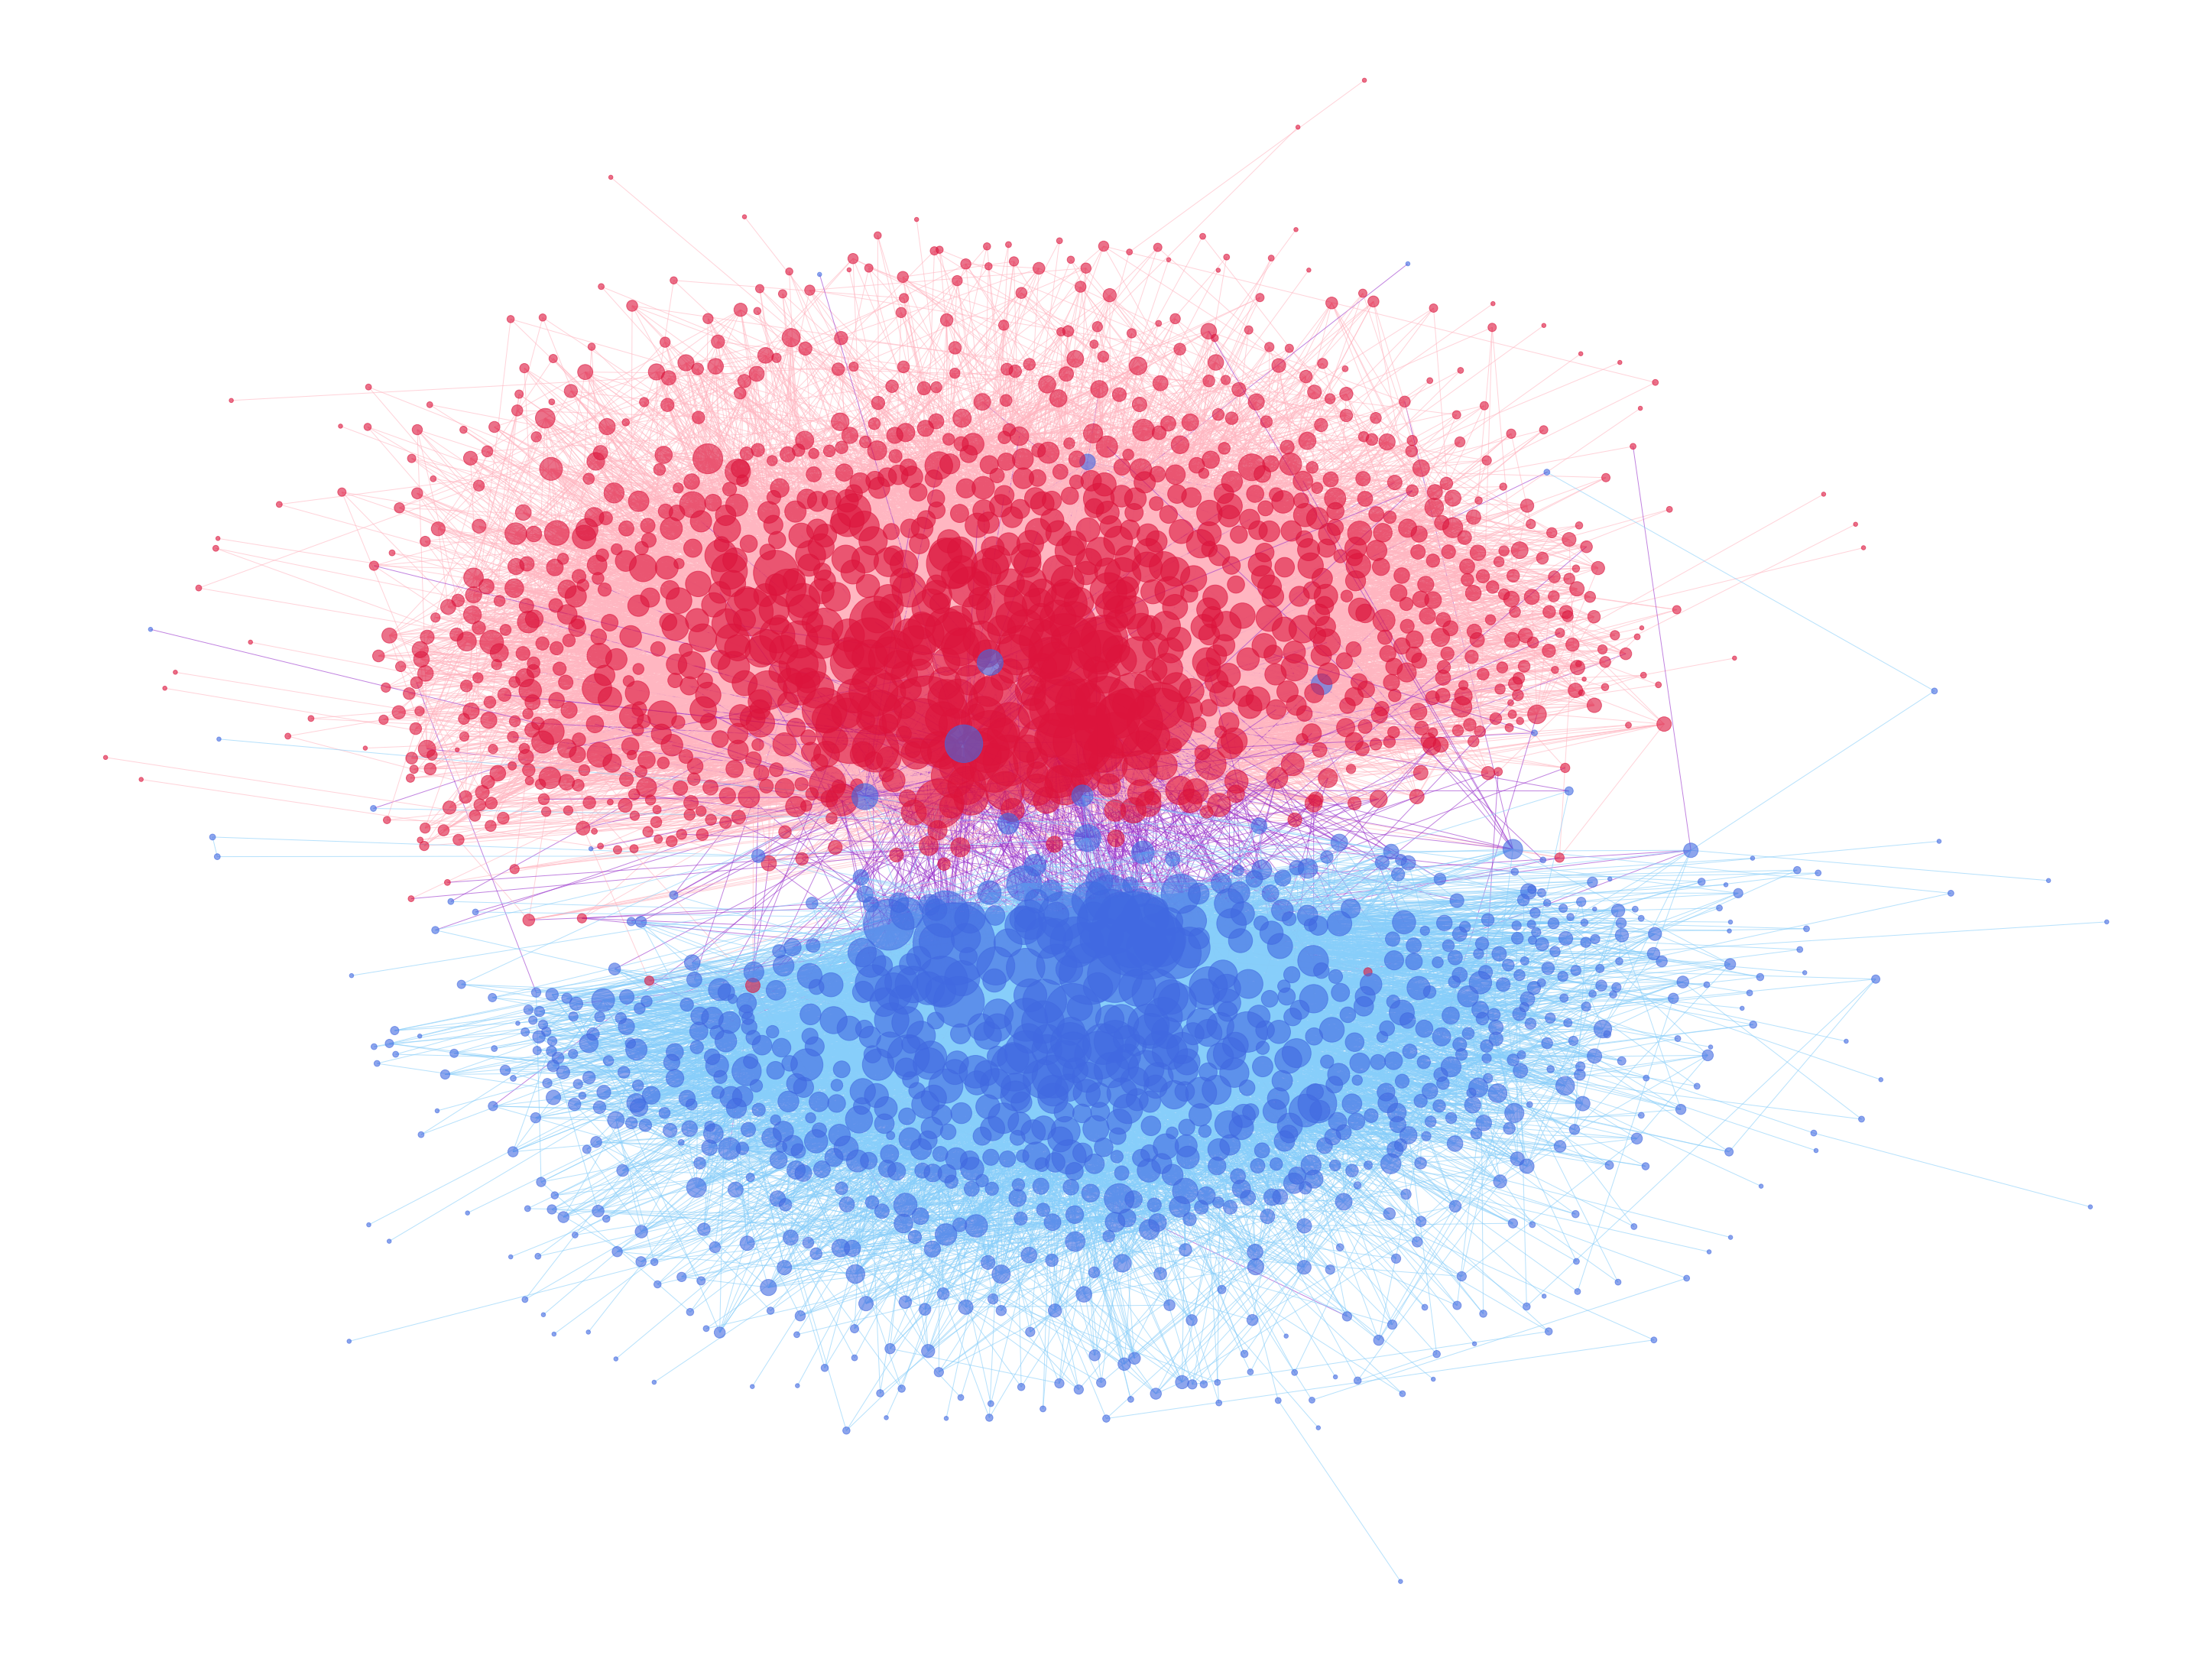

In [70]:
# visualize with draw_kamada_kawai
plt.figure(figsize=(40,30))
nx.draw_kamada_kawai(G_undirect,nodelist=d.keys(), node_size=[v * 30 for v in d.values()], node_color = color_map_nodes,alpha = 0.6,\
                    edge_color = color_map_edge)
plt.show()

### Visualization based on the Force Atlas 2 algorithm!

100%|██████████| 2000/2000 [00:38<00:00, 51.48it/s]


BarnesHut Approximation  took  13.38  seconds
Repulsion forces  took  22.99  seconds
Gravitational forces  took  0.20  seconds
Attraction forces  took  0.50  seconds
AdjustSpeedAndApplyForces step  took  0.76  seconds


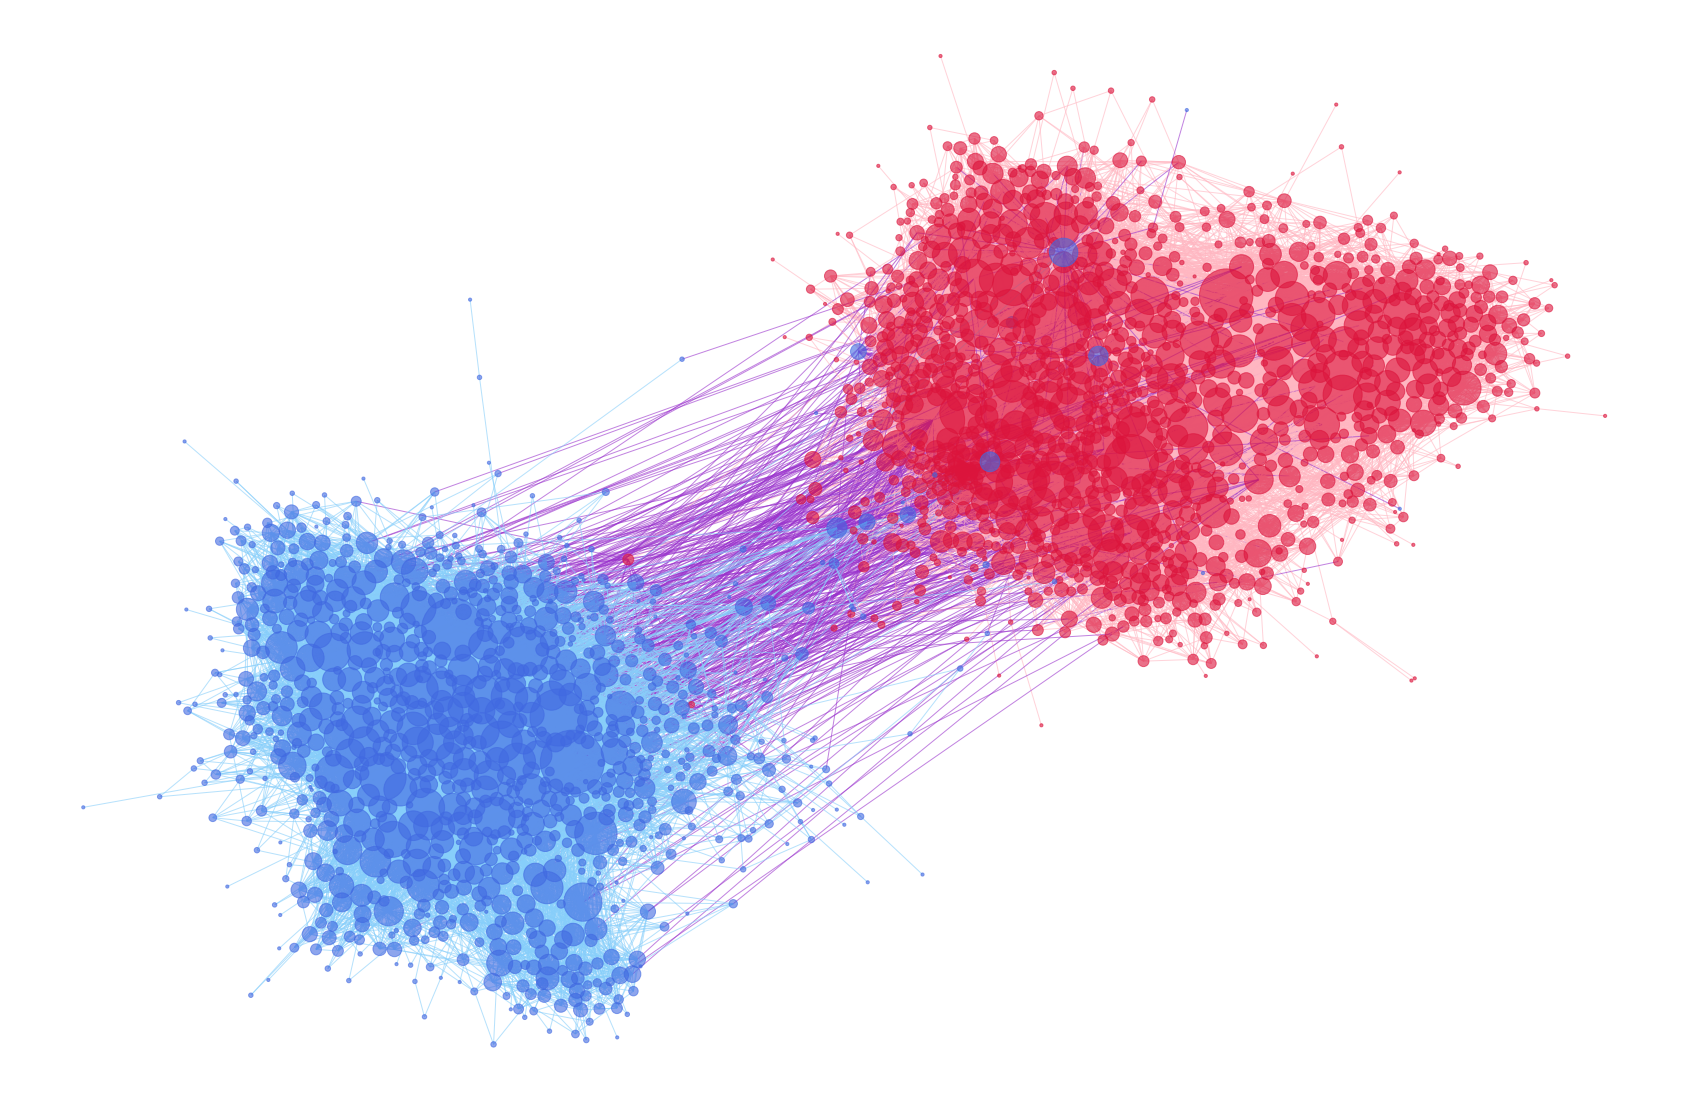

In [74]:
plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_undirect, pos=None, iterations=2000)
nx.draw_networkx(G_undirect, positions,nodelist=d.keys(), node_size=[v * 10 for v in d.values()], node_color = color_map_nodes,alpha = 0.6,\
                    edge_color = color_map_edge,with_labels=False)
plt.axis('off')
plt.show()

**Exercise 2**: Create your own version of the TF-TR word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the wiki-pages.

Here's what you need to do:

* That's it, really. The title says it all. Create your own version of the TF-TR word-clouds. Explain your process and comment on your results.

#  <font color='blue'>Exercise 2</font>

### Step 1. TF list

####  <font color='blue'>(1) Tokenize the pages into individual strings</font>

In [50]:
# data_folder = './data/character wiki pages/marvel'
data_folder = '/Users/zhengqing/desktop/character wiki pages/marvel'
# Try with Marvel Universe first

# create a list to store the wiki page text
wikipages = []
txt_files = os.listdir(data_folder)
for f in txt_files:
    file_path = os.path.join(data_folder,f)
    with open(file_path,encoding='utf-8') as f:
        text = f.read()
    wikipages.append(text)

In [18]:
# wikipages[3]

In [46]:
# Tokenize the word
text = wikipages[3]
word_tokenize(text[0:100])

['{',
 '{',
 'Infobox',
 'comics',
 'character',
 '<',
 '!',
 '--',
 'Wikipedia',
 ':',
 'WikiProject',
 'Comics',
 '--',
 '>',
 '|image=',
 'Alpha',
 'flight',
 '89',
 'guardian.jpg',
 '|']

In [20]:
tokenize = []
for text in tqdm(wikipages):
    tokenize.extend(word_tokenize(text))

100%|██████████| 1642/1642 [00:26<00:00, 63.12it/s]


In [47]:
# print the first 200 tokenize elements including punctations
print('the first 200 tokenize elements including punctations:\n{}'.format(tokenize[0:200]))

the first 200 tokenize elements including punctations:
['{', '{', 'short', 'description|Fictional', 'character', 'and', 'member', 'of', 'the', 'Young', 'Avengers', '}', '}', '{', '{', 'Infobox', 'comics', 'character|', '<', '!', '--', 'Wikipedia', ':', 'WikiProject', 'Comics', '--', '>', '|image=Speed', '(', 'Marvel', 'Character', ')', 'in', 'Young', 'Avengers', 'Number', '12', ',', 'comic', 'artwork.png', '|image_size=250', '|caption=Tommy', 'Shepherd', 'as', 'Speed', '<', 'br', '>', 'Art', 'by', '[', '[', 'Jim', 'Cheung', ']', ']', '.', '|character_name=Speed', '|real_name=Thomas', '``', 'Tommy', "''", 'Shepherd', '|species=', '[', '[', 'Mutant', '(', 'Marvel', 'Comics', ')', '|Human', 'Mutant', ']', ']', '|publisher=Marvel', 'Comics', '|debut=', "''", 'Young', 'Avengers', "''", '#', '10', '(', 'February', ',', '2006', ')', '.', '|creators=', '[', '[', 'Allan', 'Heinberg', ']', ']', '<', 'br', '/', '>', '[', '[', 'Jim', 'Cheung', ']', ']', '|alliances=', '[', '[', 'Young', 'Avengers'

####  <font color='blue'>(2) Remove all punctuation from your list of tokens</font>
####  <font color='red'>不知道是不是我数据的问题，--算标点吗 </font>

In [21]:
pattern =  r'[a-zA-Z0-9\-]+'
tokenize_nopunc = []
for w in tokenize:   
    tokenize_nopunc.extend(re.findall(pattern,w))

In [48]:
# print the first 100 tokenize words excluding punctations
print('the first 100 tokenize words excluding punctations:\n{}'.format(tokenize_nopunc[0:100]))

the first 100 tokenize words excluding punctations:
['short', 'description', 'Fictional', 'character', 'and', 'member', 'of', 'the', 'Young', 'Avengers', 'Infobox', 'comics', 'character', '--', 'Wikipedia', 'WikiProject', 'Comics', '--', 'image', 'Speed', 'Marvel', 'Character', 'in', 'Young', 'Avengers', 'Number', '12', 'comic', 'artwork', 'png', 'image', 'size', '250', 'caption', 'Tommy', 'Shepherd', 'as', 'Speed', 'br', 'Art', 'by', 'Jim', 'Cheung', 'character', 'name', 'Speed', 'real', 'name', 'Thomas', 'Tommy', 'Shepherd', 'species', 'Mutant', 'Marvel', 'Comics', 'Human', 'Mutant', 'publisher', 'Marvel', 'Comics', 'debut', 'Young', 'Avengers', '10', 'February', '2006', 'creators', 'Allan', 'Heinberg', 'br', 'Jim', 'Cheung', 'alliances', 'Young', 'Avengers', 'aliases', 'powers', 'Supersonic', 'speed', 'br', 'Molecular', 'acceleration', 'br', 'Concussive', 'Blasts', 'br', 'Superhumanly', 'fast', 'reflexes', 'br', 'Fast', 'metabolism', 'br', 'Intangibility', 'br', 'Whirlwind', 'Creati

####  <font color='blue'>(3) Set everything to lower case</font>

In [24]:
tokenize_nopunc_lower = [w.lower() for w in tokenize_nopunc]

In [51]:
# check if the first 100 words have been set to lower case
print('the first 100 tokenize words:\n{}'.format(tokenize_nopunc_lower[0:100]))

the first 100 tokenize words:
['short', 'description', 'fictional', 'character', 'and', 'member', 'of', 'the', 'young', 'avengers', 'infobox', 'comics', 'character', '--', 'wikipedia', 'wikiproject', 'comics', '--', 'image', 'speed', 'marvel', 'character', 'in', 'young', 'avengers', 'number', '12', 'comic', 'artwork', 'png', 'image', 'size', '250', 'caption', 'tommy', 'shepherd', 'as', 'speed', 'br', 'art', 'by', 'jim', 'cheung', 'character', 'name', 'speed', 'real', 'name', 'thomas', 'tommy', 'shepherd', 'species', 'mutant', 'marvel', 'comics', 'human', 'mutant', 'publisher', 'marvel', 'comics', 'debut', 'young', 'avengers', '10', 'february', '2006', 'creators', 'allan', 'heinberg', 'br', 'jim', 'cheung', 'alliances', 'young', 'avengers', 'aliases', 'powers', 'supersonic', 'speed', 'br', 'molecular', 'acceleration', 'br', 'concussive', 'blasts', 'br', 'superhumanly', 'fast', 'reflexes', 'br', 'fast', 'metabolism', 'br', 'intangibility', 'br', 'whirlwind', 'creation', 'speed', 'thomas'

####  <font color='blue'>(4) (Optional) Lemmatize your words</font>

In [26]:
porter = nltk.PorterStemmer()
tokenize_nopunc_lower_lemmatize = [porter.stem(w) for w in tokenize_nopunc_lower]

In [52]:
# check if the first 100 words have been lemmatized
print('the first 100 tokenize words:\n{}'.format(tokenize_nopunc_lower_lemmatize[0:100]))

the first 100 tokenize words:
['short', 'descript', 'fiction', 'charact', 'and', 'member', 'of', 'the', 'young', 'aveng', 'infobox', 'comic', 'charact', '--', 'wikipedia', 'wikiproject', 'comic', '--', 'imag', 'speed', 'marvel', 'charact', 'in', 'young', 'aveng', 'number', '12', 'comic', 'artwork', 'png', 'imag', 'size', '250', 'caption', 'tommi', 'shepherd', 'as', 'speed', 'br', 'art', 'by', 'jim', 'cheung', 'charact', 'name', 'speed', 'real', 'name', 'thoma', 'tommi', 'shepherd', 'speci', 'mutant', 'marvel', 'comic', 'human', 'mutant', 'publish', 'marvel', 'comic', 'debut', 'young', 'aveng', '10', 'februari', '2006', 'creator', 'allan', 'heinberg', 'br', 'jim', 'cheung', 'allianc', 'young', 'aveng', 'alias', 'power', 'superson', 'speed', 'br', 'molecular', 'acceler', 'br', 'concuss', 'blast', 'br', 'superhumanli', 'fast', 'reflex', 'br', 'fast', 'metabol', 'br', 'intang', 'br', 'whirlwind', 'creation', 'speed', 'thoma', 'tommi']


####  <font color='blue'>(5) Create TF list for Marvel universe</font>

In [30]:
marvel_tf_list = nltk.FreqDist(tokenize_nopunc_lower_lemmatize)
marvel_tf_list

FreqDist({'the': 225920, 'and': 96942, 'of': 95029, 'ref': 92942, 'to': 90457, 'comic': 74953, 'a': 70806, 'in': 68884, 'marvel': 52240, 's': 42317, ...})

###  <font color='blue'>Repeat the five steps for the DC Universe</font>

In [31]:
# define a function
def tf_list_generate(data_folder):
    # the list we used for store the wiki page text
    wikipages = []
    txt_files = os.listdir(data_folder)
    for f in txt_files:
        file_path = os.path.join(data_folder,f)
        with open(file_path,encoding='utf-8') as f:
            text = f.read()
        wikipages.append(text)
        
    # 1. Tokenize the pages into individual strings

    from nltk.tokenize import word_tokenize
    from tqdm import tqdm
    tokenize = []
    for text in tqdm(wikipages):
        tokenize.extend(word_tokenize(text))
    
    # 2. Remove all punctuation from your list of tokens
    import re
    # pattern =  r'^[a-zA-Z0-9][a-zA-Z0-9\-]*[a-zA-Z0-9]$|[a-zA-Z0-9]'
    pattern =  r'[a-zA-Z0-9\-]+'
    tokenize_nopunc = []
    for w in tokenize:   
        tokenize_nopunc.extend(re.findall(pattern,w)) # w.isalnum()  function could not extract '3-D'
#     print('the first 100 "word"(fake?) of tokenize:\n{}'.format(tokenize_nopunc[0:100]))
    
    # 3. Set everything to lower case
    tokenize_nopunc_lower = [w.lower() for w in tokenize_nopunc]
    
    # 4. (Optional) Lemmatize your words
    import nltk
    porter = nltk.PorterStemmer()
    tokenize_nopunc_lower_lemmatize = [porter.stem(w) for w in tokenize_nopunc_lower]
    
    #  5. Create your TF list for dc universe.
    tf_list = nltk.FreqDist(tokenize_nopunc_lower_lemmatize)
    
    return tf_list

In [32]:
# data_folder_dc = './data/character wiki pages/dc'
data_folder_dc = '/Users/zhengqing/desktop/character wiki pages/dc'
dc_tf_list = tf_list_generate(data_folder_dc)

100%|██████████| 1417/1417 [00:29<00:00, 48.02it/s]


In [38]:
dc_tf_list

FreqDist({'the': 258011, 'of': 119330, 'and': 105617, 'to': 98079, 'in': 88715, 'a': 85663, 'ref': 66131, 'comic': 59306, 's': 51768, 'is': 40699, ...})

### Step 2. Word weights

In [44]:
# define a function to generate tf-tr list
def tf_tr_generate(tf_dict_self,tf_dict_other,c):
    tf_tr_list = {}
    for each in tf_dict_self:
        tf_self = tf_dict_self[each]
        tf_other = tf_dict_other[each] if each in tf_dict_other else 0
        w = tf_self/(tf_other + c)
        tf_tr_list[each] = w*tf_self
    return tf_tr_list

c = 100
marvel_tf_tr = tf_tr_generate(marvel_tf_list,dc_tf_list,c)
dc_tf_tr = tf_tr_generate(dc_tf_list,marvel_tf_list,c)

# sorted
marvel_tf_tr = sorted(marvel_tf_tr.items(), key=lambda item: item[1],reverse = True)
dc_tf_tr = sorted(dc_tf_tr.items(), key=lambda item: item[1],reverse = True)

In [45]:
# Check out top 10 for each universe. Does it make sense?
print('top 10 for TF-TR in marvel universe:\n{}'.format(marvel_tf_tr[:10]))
print('***********************')
print('top 10 for TF-TR in DC universe:\n{}'.format(dc_tf_tr[:10]))

top 10 for TF-TR in marvel universe:
[('x-men', 1263620.0478723403), ('marvel', 886332.4455992206), ('aveng', 473967.0406654344), ('spider-man', 423327.82102908276), ('mutant', 281387.03071672353), ('the', 197743.78620051063), ('wolverin', 171579.3913043478), ('thor', 168682.5), ('hulk', 165212.16571428571), ('ref', 130425.56150443146)]
***********************
top 10 for TF-TR in DC universe:
[('batman', 2642635.8288770053), ('dc', 1502926.0353817504), ('superman', 1464024.9943820224), ('leagu', 408295.6611842105), ('justic', 328070.51024590165), ('the', 294530.0244270419), ('lantern', 282033.2861356932), ('bizarro', 189944.55445544556), ('of', 149687.78080290975), ('gotham', 119526.14545454545)]


### Step three: Install the software

In [53]:
! pip install wordcloud

     |████████████████████████████████| 162 kB 1.9 MB/s eta 0:00:01


### Step four: Draw the wordclouds

In [54]:
# The package needs a single string to work on
# convert the freq list to the string

def tf_tr_to_string(tf_tr_list):
    word_list = []
    for w,tf_tr in tf_tr_list:
        times = round(tf_tr)
        word_list.extend([w]*times)
    string = ' '.join(word_list)
    return string

marvel_str = tf_tr_to_string(marvel_tf_tr)
dc_str = tf_tr_to_string(dc_tf_tr)

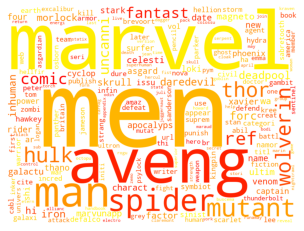

In [55]:
# create a word cloud for Marvel universe
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(
    max_words= 200,
    background_color = 'white',
                      width=800,
                      height=600,
                        collocations=False,
    colormap= 'autumn'
                     ).generate(marvel_str)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

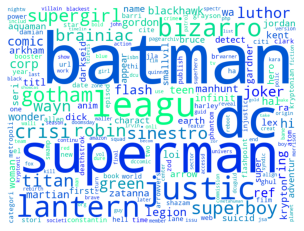

In [56]:
# Word cloud for DC universe
wordcloud = WordCloud(
    max_words= 200,
    background_color = 'white',
                      width=800,
                      height=600,
                        collocations=False,
    colormap= 'winter'
                     ).generate(dc_str)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Exercise 3**: Find communities and create associated TF-IDF word clouds (from lecture 7 and 8). In this exercise, we assume that you have been able to find communities in your network. It's OK to only work on a single universe in this one.

Here's what you need to do:
* Explain briefly how you chose to identify the communities: Which algorithm did you use, how does it work?
* How many communities did you find in total?
* Plot the distribution of community sizes.
* For the 5-10 largest communities, create TF-IDF based rankings of words in each community. There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.
* Create a word-cloud displaying the most important words in each community (according to TF-IDF). Comment on your results (do they make sense according to what you know about the superhero characters in those communities?)

#  <font color='blue'>Exercise 3</font>

In [76]:
# check code in preparation part

# get the undirected version of the whole network

G_undirect = G.to_undirected()

In [75]:
# calculate L_marvel and L_dc


# get the sub network of Marvel and DC first
# get the list of DC/Marvel characters
dc_cha = []
marvel_cha = []
for node in G_undirect.nodes():
    if nx.get_node_attributes(G_undirect,'type')[node] == 'Marvel':
        marvel_cha.append(node)
    else:
        dc_cha.append(node)

# get the subgraph from the list
DC_network = G_undirect.subgraph(dc_cha)
Marvel_network = G_undirect.subgraph(marvel_cha)

# L_Marvel = links in Marvel_netwrok; same as DC
L_marvel = len(Marvel_network.edges())
L_dc = len(DC_network.edges())
print('L_marvel={}\tL_dc={}'.format(L_marvel,L_dc))

L_marvel=15835	L_dc=10818


In [77]:
# get the total degree of the nodes in marvel/dc community
k_marvel = sum([v for name,v in G_undirect.degree(marvel_cha)])
k_dc = sum([v for name,v in G_undirect.degree(dc_cha)])
print('k_marvel={}\tk_dc={}'.format(k_marvel,k_dc))

k_marvel=32376	k_dc=22342


In [78]:
# calculate the M 
import math
L = len(G_undirect.edges())
M = L_marvel/L - math.pow((k_marvel/(2*L)),2)  + L_dc/L - math.pow((k_dc/(2*L)),2)
print('M={}'.format(M))

M=0.457381477229442


**Exercise 4**: Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities. Unlike above - we work all communities. It's still OK to work with data from a single universe. More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below;
* We name each community by its three most connected characters.
* Average the average sentiment of the nodes in each community to find a community level sentiment.

Here's what you need to do:
* Calculate and store sentiment for every single page. 
* Create a histogram of all character's associated page-sentiments.
* What are the 10 characters with happiest and saddest pages?
* What are the three happiest communities?
* what are the three saddest communities?
* Do these results confirm what you can learn about each community by skimming the wikipedia pages?